In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%cd ..

/ships19/cloud/scratch/cphillips/isccp_l1g


In [3]:
import os

In [4]:
os.environ['TEMP'] = os.getcwd()

In [5]:
import make_geometry

In [6]:
from pathlib import Path

In [7]:
import xarray as xr

In [8]:
from tqdm import tqdm

In [9]:
from utils import ALL_SATS
from collect_l1b import L1B_DIR
from make_index import get_area

In [39]:
dt_dir = Path('l1b/2020/07/01/0000/')
with tqdm(ALL_SATS) as bar:
    for attrs in bar:
        sat = attrs['sat']
        reader = attrs['reader']

        files = list((dt_dir / sat / f'temp_11_00um').glob('*'))
        area = get_area(files, reader=reader)
        break

  0%|          | 0/5 [00:00<?, ?it/s]


In [47]:
height, width = area.shape
proj = area.to_cartopy_crs()
xang, yang = make_geometry.get_geostationary_angle_extent(area)
x,y = np.meshgrid(np.linspace(-xang, xang,width, dtype=np.float32),
                  np.linspace(-yang, yang, height, dtype=np.float32))
h = proj.proj4_params['h']
lon,lat = make_geometry.ccrs.PlateCarree().transform_points(proj, y*h, x*h).T[:2]

In [48]:
a = np.deg2rad(lon - proj.proj4_params['lon_0'])
b = np.deg2rad(lat)

In [55]:
satazi = make_geometry.sensor_azimuth(proj.proj4_params['lon_0'], 0, lon,lat)

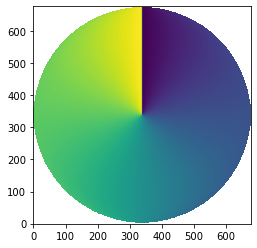

In [62]:
imshow(satazi[::8,::8], origin='lower')

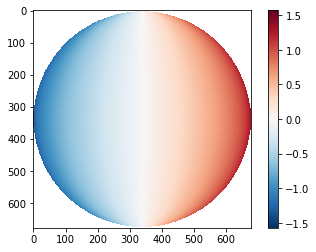

In [54]:
imshow(a[::8,::8], vmin=-np.pi/2, vmax=np.pi/2, cmap='RdBu_r')
colorbar()

In [41]:
sat_azi = get_satazi(area)

Area ID: GOES-East
Description: 2km at nadir
Projection ID: abi_fixed_grid
Projection: {'ellps': 'GRS80', 'h': '35786023', 'lon_0': '-75', 'no_defs': 'None', 'proj': 'geos', 'sweep': 'x', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 5424
Number of rows: 5424
Area extent: (-5434894.8851, -5434894.8851, 5434894.8851, 5434894.8851)

In [10]:
#f = Path('composite_cache/wmo_id.nc')

In [26]:
f = next(ROOT.glob('*/*/*/*/*wmo_id*'))

In [27]:
ds = xr.open_dataset(f)
wmo_id = ds.wmo_id.squeeze()
ds.close()

In [ ]:
with tqdm(wmo_ids) as bar:
    for f in bar:

        break

In [28]:
satazi = wmo_id.copy(deep=True)
satazi[:] = np.nan
lon,lat = np.meshgrid(satazi.longitude, satazi.latitude)

In [29]:
for attrs in ALL_SATS:
    masks = wmo_id == attrs['wmo_id']
    azi = make_geometry.sensor_azimuth(attrs['lon'], 0, lon, lat)
    for layer,mask in enumerate(masks):
        satazi.values[layer][mask] = azi[mask]

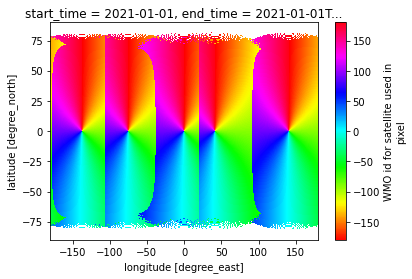

In [30]:
satazi[0].plot.imshow(cmap='hsv', vmin=-180, vmax=180)

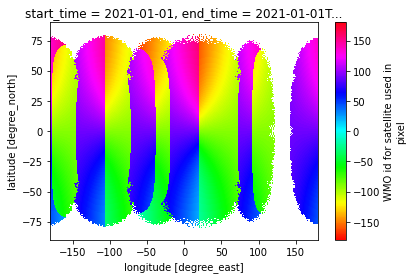

In [31]:
satazi[1].plot.imshow(cmap='hsv', vmin=-180, vmax=180)

In [32]:
ds = xr.Dataset()
ds['satellite_azimuth'] = satazi

In [34]:
ds.to_netcdf('composite_cache/satazi.nc', encoding=make_geometry.SATAZI_ENCODING)

In [59]:
# sublon = {}
# h = {}
# with tqdm(ALL_SATS) as bar:
#     for attrs in bar:
#         sat = attrs['sat']
#         reader = attrs['reader']
#         band_lookup = attrs['bands']
#         bar.set_description(sat)
#         for dir in L1B_DIR.glob(f'*/*/*/*/{sat}'):
#             band = band_lookup['temp_11_00um']
#             files = list(dir.glob('temp_11_00um/*'))
#             area = get_area(files, reader=reader)
#             sublon[sat] = area.proj_dict['lon_0']
#             h[sat] = area.proj_dict['h']
#             break